# Mini-projet Groupe 1 : Charge d'une flotte de véhicules électriques

## 1. Modélisation

### Question 1 :

Notons $\tau\,=\,\frac{q}{q_{max}}$ où $q$ est la charge absolue de la batterie, $q_{max}$ la charge absolue maximale et $P$ la puissance fournie à la batterie. 

On suppose qu'il y a toujours assez de bornes de recharge pour les voitures qui souhaitent être rechargées. On note $n$ le nombre de voitures et pour chaque voiture $j$ le temps $t^0_j$ d'arrivée et $t^f_j$ le temps de départ ainsi que $\tau^0_j$ et $\tau^f_j$ les taux de charge relatifs à l'arrivée et au départ.

Notons f la fonction objectif du problème qui est le coût de recharge lié à la consommation électrique qui dépend de l'intensité $I_j$ qui parcourt chaque borne de recharge $j$ à tout instant.
    
$f(I)\,=\,\int^{t_f}_{t_0}\sum_{j=1}^nI_j(t)\,Up(t)dt$ où $t_0 = \displaystyle \max_{j}(t^0_j)$, $t_f = \displaystyle \max_{j}(t^f_j)$, $U$ la tension du réseau (que l'on suppose fixe égale à $230 V$) et $p(t)$ est le prix de l'électricité en euros/$kWh$.

### Question 2 :

On suppose que les batteries des voitures sont identiques. 


On a : $\frac{dq}{dt}(t) = \alpha\,I(t) = \alpha\,\frac{P(t)}{U}$ d'où : $\frac{d\tau}{dt}(t) =\alpha\, \frac{P(t)}{U*q_{max}}$ où $\alpha$ est un facteur lié aux pertes diverses de charge (effet Joule, cablage...) à déterminer expérimentalement. 

### Question 3 :

On va ici traiter de l'évaluation expérimentale de notre modèle, i.e. le calcul par la régression (linéaire dans notre cas, puisque la relation q(I) est linéaire). On trace d'après les données fournies $\frac{dq}{dt}(t)$ en fonction de $I(t)$.

In [6]:
#traitement des données, mise en forme sous un panda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

table = pd.read_table('donnees-projet-gr1.txt', names=['temps', 'intensité', 'charge_relative'])
table.head()

,temps,intensité,charge_relative
0,0.000000,0.005755,0.626524
1,1.005016,0.018529,0.631323
2,2.008215,-0.022398,0.629266
3,3.018137,0.008812,0.631987
4,4.023168,0.003566,0.632518


In [2]:
### On calcule la dérivée de la charge
table_der = table.copy(deep = True)
table_der['derivee_charge'] = 0
for i in table_der.index :
    if i == 0:
        table_der.iloc[i, 3] = 0
    else :
        table_der.iloc[i, 3] = (table_der.iloc[i-1, 2] - table_der.iloc[i, 2])/(table_der.iloc[i-1, 0] - table_der.iloc[i, 0])
table_der.drop([0], inplace = True) ### On supprime la première ligne car on a pas la dérivée de la charge pour cette ligne.
table_der.head()

,temps,intensité,charge_relative,derivee_charge
1,1.005016,0.018529,0.631323,0.004775
2,2.008215,-0.022398,0.629266,-0.002050
3,3.018137,0.008812,0.631987,0.002694
4,4.023168,0.003566,0.632518,0.000529
5,5.027335,-0.012886,0.632880,0.000360


In [3]:
### On crée notre fonction objectif
def f(a):
    s = 0
    for i in table_der.index :
        s += (table_der.loc[i, 'derivee_charge'] - a*table_der.loc[i, 'intensité'])**2
    return s

In [4]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(f)
res

     fun: 0.002029256395442698
    nfev: 27
     nit: 23
 success: True
       x: 0.0019426071168044741

On trouve donc que $\frac{d\tau}{dt} = 0.00194 \times I$ avec une erreur de 0.00203.

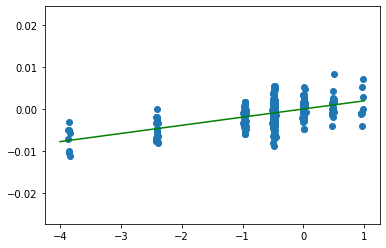

In [5]:
plt.scatter(table_der['intensité'], table_der['derivee_charge'])
x = np.linspace(-4, 1)
plt.plot(x, 0.0019426071168044741*x, 'g')

### Question 4 :

Nous avons donc la fonction objectif du problème $f$ qu'il faut minimiser et une relation entre le taux de charge relatif $\tau_j$ et l'intensité parcourant la batterie $I_j$. Ecrivons à présent les contraintes du porblème. 

- $I_j(t) = 0$ pour $t \notin [t_j^0, t_j^f]$ : la voiture ne peut pas charger si elle n'est pas là.
- $\tau_j(t) \in [0, 1]$ pour tout $t$ et tout $j$ : le taux de charge relatif est compris entre 0 et 1.
- $\tau_j(t_j^f) \geq \tau^f_j$ : le taux de charge de la voiture j lorsque la voiture part est supérieur ou égal au taux de charge final voulu.
- $I(t) \geq 0$ pour tout $t$ : l'intensité traversant la batterie est toujours positive de sorte que la batterie se recharge forcèment.
- $\sum_{j=1}^n I_j(t)U \leq P_{max}$ pout tout $t$ : la puissance fournie à tout instant t aux voitures ne dépasse pas la puissance maximale $P_max$ du réseau. 

On peut ensuite passer à une version discrétisée du problème pour avoir un problème d'optimisation sous contraintes en dimension finie : ...